## 1.计算香农熵

In [17]:
import math

In [10]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1] # 看后面以最后一列作为key
        labelCounts[currentLabel] = labelCounts.get(currentLabel,0) + 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries # 计算概率
        shannonEnt -= prob * math.log(prob,2) # 这是计算公式，2为底的log函数与概率的乘积
    return shannonEnt

## 2.测试熵的计算

In [4]:
def createDataSet():
    dataSet = [
        [1,1,'yes'],
        [1,1,'yes'],
        [1,0,'no'],
        [0,1,'no'],
        [0,1,'no']
    ]
    labels = ['no surfacing','flippers']
    return dataSet,labels

In [10]:
data,labels = createDataSet()
print(calcShannonEnt(data))

0.9709505944546686


In [11]:
data[0][-1] = 'xxx'
print(calcShannonEnt(data))

1.3709505944546687


**数据越混乱，熵越大**

## 2.划分数据集

In [11]:
def splitDataSet(dataSet,axis,value):
    retDataSet = [] # 新建一个，因为传的是引用
    for row in dataSet:
        if row[axis] == value:
            # 下面的拆分去掉了axis这一项
            reducedRow = row[:axis]
            reducedRow.extend(row[axis+1:])
            retDataSet.append(reducedRow)
    return retDataSet

In [14]:
# 关于extend和append的区别
a = [1,2,3]
b = [4,5,6]
a.append(b)
print(a)
a.extend(b)
print(a)

[1, 2, 3, [4, 5, 6]]
[1, 2, 3, [4, 5, 6], 4, 5, 6]


## 4.测试划分

In [16]:
data,labels = createDataSet()
print(data)
print(splitDataSet(data,0,0))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
[[1, 'no'], [1, 'no']]


## 5.选择最好的划分数据集

In [12]:
def chooseBestFetureToSplit(dataSet):
    numFetures = len(dataSet[0]) - 1
    baseEntroy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0;bestFeture = -1
    for i in range(numFetures):
        fetureList = [example[i] for example in dataSet]
        uniqueVals = set(fetureList) # 唯一的分类标签列表
        newEntroy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet,i,value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntroy += prob * calcShannonEnt(subDataSet) # 这是求香农熵的均值公式
        # 信息增益,变小才是有增益
        infoGain = baseEntroy - newEntroy 
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeture = i
    return bestFeture

In [18]:
# 测试下
data,labels = createDataSet()
print(data)
print(chooseBestFetureToSplit(data))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
0


**结果表示按第0个特征进行划分最好（总共就2个特征）**

## 6.计算每个类别频率

In [1]:
import operator

In [8]:
def majorityCnt(classList):
    classCount = {}
    for cls in classList:
        classCount[cls] = classCount.get(cls,0) + 1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0] # 选出现频率最多的

In [9]:
# 测试
data,labels = createDataSet()
print(data)
print(majorityCnt([example[-1] for example in data]))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
no


## 7.创建决策树

In [15]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    # 类别完全相同时停止划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 当遍历完所有特征时返回出现次数最多的
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeature = chooseBestFetureToSplit(dataSet)
    bestFetureLabel = labels[bestFeature]
    myTree = {bestFetureLabel:{}}
    del(labels[bestFeature])
    # 得到列表包含的所有属性值
    featureValue = [example[bestFeature] for example in dataSet]
    uniqueVals = set(featureValue)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFetureLabel][value] = createTree(splitDataSet(dataSet,bestFeature,value),subLabels) # 递归
    return myTree

In [13]:
a = {'1':1,'2':2}
del(a['1'])
print(a)

{'2': 2}


In [14]:
# 测试决策树，这次试用新的数据集
def newData():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet, labels

In [18]:
dataSet,labels = newData()
myTree = createTree(dataSet,labels)
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## 8.绘制树型图

### 8.1 使用matplot注解

In [23]:
#-*-coding:utf-8-*-
import matplotlib.pyplot as plt

In [20]:
# 定义样式
decisionNode = dict(boxstyle='sawtooth',fc='0.8')
leafNode = dict(boxstyle='round4',fc='0.8')
arrow_args = dict(arrowstyle='<-')

In [28]:
# 使用全局变量
def plotNode(nodeText,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeText,xy=parentPt,xycoords='axes fraction',\
                            xytext=centerPt,textcoords='axes fraction',va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)

In [29]:
def createPlot():
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111,frameon=False) # 全局变量
    plotNode(u'决策节点',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode(u'叶子节点',(0.8,0.1),(0.3,0.9),leafNode)
    plt.show()

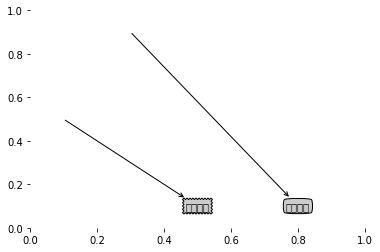

In [30]:
    createPlot()

### 8.2  准备树的信息
要绘制树得确定x和y的范围，即树的叶子节点个数和深度

In [39]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs += 1
    return numLeafs

In [40]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstkey = list(myTree.keys())[0]
    secondDict = myTree[firstkey]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            depth = 1 + getTreeDepth(secondDict[key])
        else: depth = 1
        maxDepth = depth if depth > maxDepth else maxDepth
    return maxDepth

In [42]:
# 测试
tree = {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
print(type(tree))
print(getNumLeafs(tree))
print(getTreeDepth(tree))

<class 'dict'>
3
2


## 9.测试决策树

In [48]:
def classify(inputTree,labels,testVec):
    firstKey = list(inputTree.keys())[0]
    secondDict = inputTree[firstKey]
    featureIndex = labels.index(firstKey)
    for key in secondDict:
        if testVec[featureIndex] == key:
            if type(secondDict[key]).__name__=='dict':
                classLabel = classify(secondDict[key],labels,testVec)
            else: classLabel = secondDict[key] #是叶子节点
    return classLabel

In [45]:
def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

In [49]:
labels = ['no surfacing','flippers']
tree = retrieveTree(0)
print(tree)
print(classify(tree,labels,[1,0]))
print(classify(tree,labels,[1,1]))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
no
yes


## 10.存储决策树
因为每次构建很耗时，可以使用pickle模块存在硬盘里

In [55]:
def storeTree(inputTree,filename):
    import pickle
    with open(filename,'wb') as f:
        pickle.dump(inputTree,f)

In [57]:
def grabTree(filename):
    import pickle
    with open(filename,'rb') as f:
        return pickle.load(f)

In [58]:
# 测试
tree = retrieveTree(0)
storeTree(tree,'05-tree.txt')
print(grabTree('05-tree.txt'))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
